In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.4.1


In [ ]:
batch_size = 32
epochs = 20
image_size = (300,300)
test_size = 0.2

In [ ]:
training_images = tf.io.gfile.glob('drive/My Drive/Colab Notebooks/chest_xray/train/*/*')
validation_images = tf.io.gfile.glob('drive/My Drive/Colab Notebooks/chest_xray/val/*/*')

In [ ]:
print(f'Przed podziałem 80:20')
print(f'Obrazy treningowe = {len(training_images)}')
print(f'Obrazy walidacyjne = {len(validation_images)}\n')


total_files = training_images
total_files.extend(validation_images)
print(f'Łączna ilość obrazów = {len(total_files)}\n')

train_images, val_images = train_test_split(total_files, test_size = test_size)
print(f'Po podziale 80:20')
print(f'Obrazy treningowe = {len(train_images)}')
print(f'Obrazy walidacyjne = {len(val_images)}')

Liczba zdjęć ze zdrowymi płucami = 1063
Liczba zdjęć z zapaleniem płuc = 3122


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


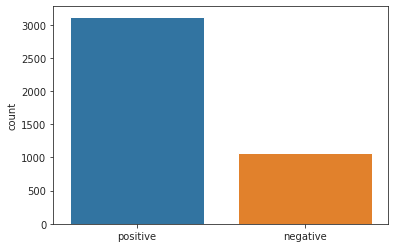

In [ ]:
count_normal = len([x for x in train_images if "NORMAL" in x])
print(f'Liczba zdjęć ze zdrowymi płucami = {count_normal}')

count_pneumonia = len([x for x in train_images if "PNEUMONIA" in x])
print(f'Liczba zdjęć z zapaleniem płuc = {count_pneumonia}')

count_array = []
count_array += ['positive']*count_pneumonia
count_array += ['negative']*count_normal

sns.set_style('ticks')
sns.countplot(count_array)

In [ ]:
tf.io.gfile.makedirs('/kaggle/working/val_dataset/negative/')
tf.io.gfile.makedirs('/kaggle/working/val_dataset/positive/')
tf.io.gfile.makedirs('/kaggle/working/train_dataset/negative/')
tf.io.gfile.makedirs('/kaggle/working/train_dataset/positive/')

In [ ]:
for ele in train_images:
    parts_of_path = ele.split('/')

    if 'PNEUMONIA' == parts_of_path[-2]:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/train_dataset/positive/' +  parts_of_path[-1])
    else:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/train_dataset/negative/' +  parts_of_path[-1])

In [ ]:
for ele in val_images:
    parts_of_path = ele.split('/')

    if 'PNEUMONIA' == parts_of_path[-2]:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/val_dataset/positive/' +  parts_of_path[-1])
    else:
        tf.io.gfile.copy(src = ele, dst = '/kaggle/working/val_dataset/negative/' +  parts_of_path[-1])

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                 rotation_range = 20,
                                 zoom_range = 0.2,
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1/255)
                                

train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/train_dataset/',
    target_size = image_size,
    batch_size = batch_size ,
    class_mode = 'binary'
)

validation_generator = val_datagen.flow_from_directory(
    '/kaggle/working/val_dataset/',
    target_size = image_size,
    batch_size = batch_size ,
    class_mode = 'binary'
)

Found 4185 images belonging to 2 classes.
Found 1047 images belonging to 2 classes.


In [ ]:
eval_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = eval_datagen.flow_from_directory(
    'drive/My Drive/Colab Notebooks/chest_xray/test',
    target_size = image_size,
    batch_size = batch_size , 
    class_mode = 'binary'
)

Found 624 images belonging to 2 classes.


In [ ]:
initial_bias = np.log([count_pneumonia/count_normal])
initial_bias

array([1.07737872])

In [ ]:
weight_for_0 = (1 / count_normal)*(len(train_images))/2.0 
weight_for_1 = (1 / count_pneumonia)*(len(train_images))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Waga dla 0: {:.2f}'.format(weight_for_0))
print('Waga dla 1: {:.2f}'.format(weight_for_1))

Waga dla 0: 1.97
Waga dla 1: 0.67


# **VGG**

In [ ]:
base_model3 = tf.keras.applications.VGG16(input_shape=(300, 300, 3),include_top=False, weights='imagenet')
base_model3.trainable = False

model3 = tf.keras.Sequential([
        base_model3,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
        ])

model3.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy', 'Precision','Recall']) #RMSprop
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               21234176  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
checkpoint_cb3 = tf.keras.callbacks.ModelCheckpoint("model2_vgg.h5",
                                                    save_best_only=True)

early_stopping_cb3 = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience=20, mode = 'min',restore_best_weights=True)

In [ ]:
history1 = model3.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    class_weight = class_weight,
    callbacks = [checkpoint_cb3, early_stopping_cb3]
)

Epoch 1/20
130/130 [==============================] - 126s 961ms/step - loss: 3.6673 - accuracy: 0.6640 - precision: 0.8541 - recall: 0.6469 - val_loss: 0.3145 - val_accuracy: 0.8682 - val_precision: 0.9937 - val_recall: 0.8239
Epoch 2/20
130/130 [==============================] - 124s 953ms/step - loss: 0.2899 - accuracy: 0.8823 - precision: 0.9685 - recall: 0.8724 - val_loss: 0.3055 - val_accuracy: 0.8854 - val_precision: 0.9954 - val_recall: 0.8463
Epoch 3/20
130/130 [==============================] - 124s 957ms/step - loss: 0.2820 - accuracy: 0.8924 - precision: 0.9667 - recall: 0.8862 - val_loss: 0.1603 - val_accuracy: 0.9389 - val_precision: 0.9902 - val_recall: 0.9251
Epoch 4/20
130/130 [==============================] - 124s 955ms/step - loss: 0.2309 - accuracy: 0.9183 - precision: 0.9735 - recall: 0.9169 - val_loss: 0.1811 - val_accuracy: 0.9436 - val_precision: 0.9388 - val_recall: 0.9869
Epoch 5/20
130/130 [==============================] - 123s 949ms/step - loss: 0.2324 - a

In [ ]:
eval_result3 = model3.evaluate_generator(test_generator, 624)

print('loss', eval_result3[0])
print('accuracy', eval_result3[1])
print('precision', eval_result3[2])
print('recall', eval_result3[3])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss 0.2008327692747116
accuracy 0.9278846383094788
precision 0.9503916501998901
recall 0.9333333373069763


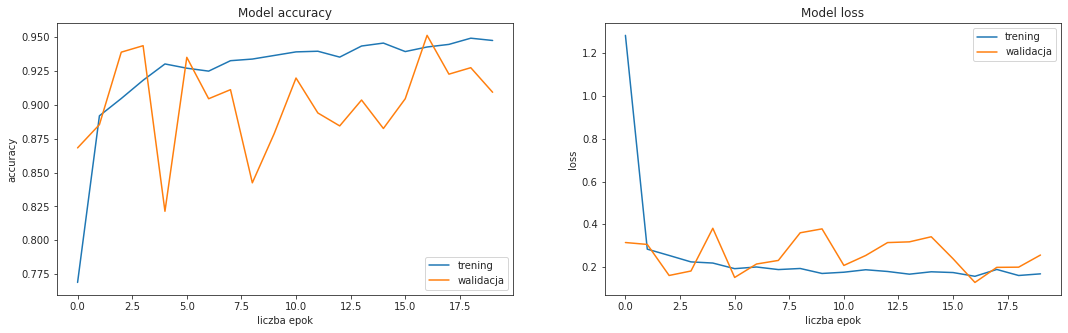

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history1.history[element])
    axis[i].plot(history1.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('liczba epok')
    axis[i].set_ylabel(element)
    axis[i].legend(['trening', 'walidacja'])

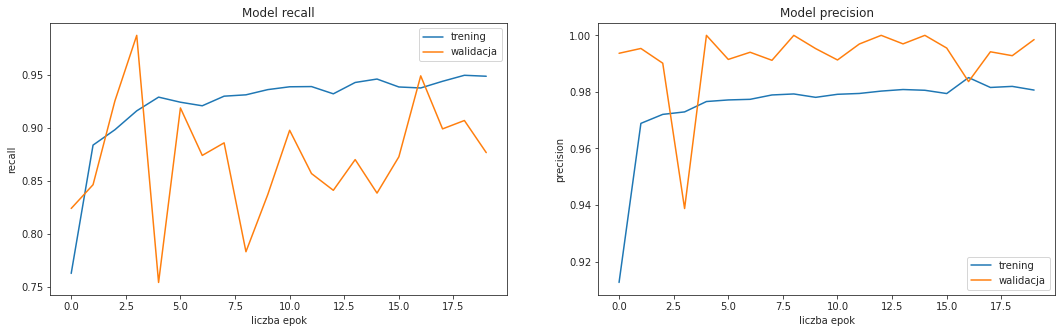

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['recall', 'precision']):
    axis[i].plot(history1.history[element])
    axis[i].plot(history1.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('liczba epok')
    axis[i].set_ylabel(element)
    axis[i].legend(['trening', 'walidacja'])

In [ ]:
vgg_model = tf.keras.models.load_model('/content/model2_vgg.h5')

wrong_predicted_image = [[],[]]
correct_predicted_image = [[],[]]
i = 0
while i< 5 and len(wrong_predicted_image[0]) < 6:
    j = 0
    while j < 32 and len(wrong_predicted_image[0]) < 6:
        
        image_array = (test_generator[i][0][j]).reshape(1,300,300,3)
        
        prediction = vgg_model.predict(image_array)
        
        if int(round(prediction[0][0])) != test_generator[i][1][j]:
            wrong_predicted_image[0].append(image_array)
            wrong_predicted_image[1].append(int(round(prediction[0][0])))
            
        elif len(correct_predicted_image[0]) < 6:
            correct_predicted_image[0].append(image_array)
            correct_predicted_image[1].append(int(round(prediction[0][0])))
        j += 1
        
    i += 1

Źle sklasyfikowane --- [1, 1, 0, 1, 1, 0]


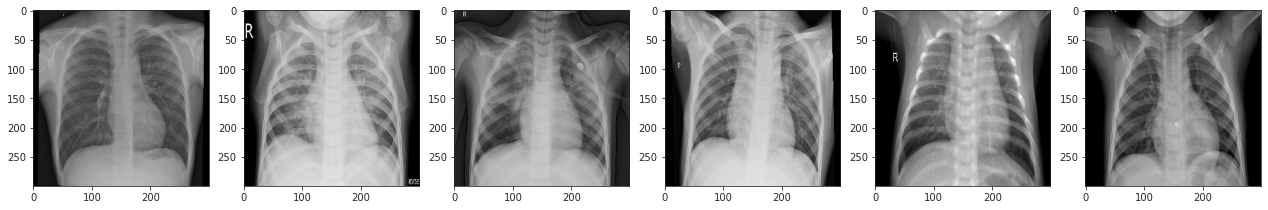

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in wrong_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'Źle sklasyfikowane --- {wrong_predicted_image[1]}')

Poprawne sklasyfikowane --- [1, 1, 1, 0, 1, 1]


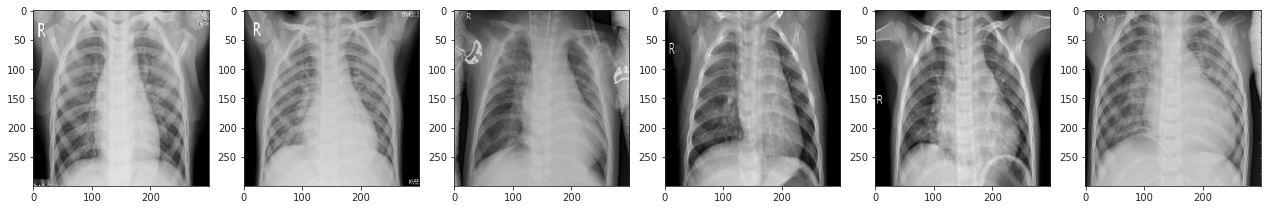

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in correct_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'Poprawne sklasyfikowane --- {correct_predicted_image[1]}')

# **Inception**

In [ ]:
base_model1 = tf.keras.applications.InceptionV3(input_shape=(300, 300, 3),include_top=False, weights='imagenet')

for layers in base_model1.layers[:200]:
    layers.trainable = False

model1 = tf.keras.Sequential([
        base_model1,
        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dense(1,activation=tf.nn.sigmoid),
        ])

model1.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy', 'Recall', 'Precision'])

model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 14,806,337
Non-trainable params: 6,998,496
_________________________________________________________________


In [ ]:
checkpoint_cb1 = tf.keras.callbacks.ModelCheckpoint("model2_inceptionNet.h5",
                                                    save_best_only=True)

early_stopping_cb1 = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience=50, mode = 'min',restore_best_weights=True)                                     

In [ ]:
history2 = model1.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    class_weight = class_weight,
    callbacks = [checkpoint_cb1, early_stopping_cb1]    
)

Epoch 1/20
130/130 [==============================] - 130s 952ms/step - loss: 0.2729 - accuracy: 0.8910 - recall: 0.8897 - precision: 0.9559 - val_loss: 0.2509 - val_accuracy: 0.9494 - val_recall: 0.9396 - val_precision: 0.9903
Epoch 2/20
130/130 [==============================] - 123s 947ms/step - loss: 0.1196 - accuracy: 0.9538 - recall: 0.9590 - precision: 0.9791 - val_loss: 0.3864 - val_accuracy: 0.9484 - val_recall: 0.9895 - val_precision: 0.9424
Epoch 3/20
130/130 [==============================] - 123s 946ms/step - loss: 0.0735 - accuracy: 0.9724 - recall: 0.9714 - precision: 0.9914 - val_loss: 0.1167 - val_accuracy: 0.9704 - val_recall: 0.9671 - val_precision: 0.9919
Epoch 4/20
130/130 [==============================] - 124s 950ms/step - loss: 0.0549 - accuracy: 0.9762 - recall: 0.9766 - precision: 0.9908 - val_loss: 0.4297 - val_accuracy: 0.8940 - val_recall: 0.8541 - val_precision: 1.0000
Epoch 5/20
130/130 [==============================] - 124s 954ms/step - loss: 0.0598 - a

In [ ]:
eval_result1 = model1.evaluate_generator(test_generator, 624)
print('loss', eval_result1[0])
print('accuracy', eval_result1[1])
print('precision', eval_result1[2])
print('recall', eval_result1[3])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss 0.24018120765686035
accuracy 0.9455128312110901
precision 0.964102566242218
recall 0.9494949579238892


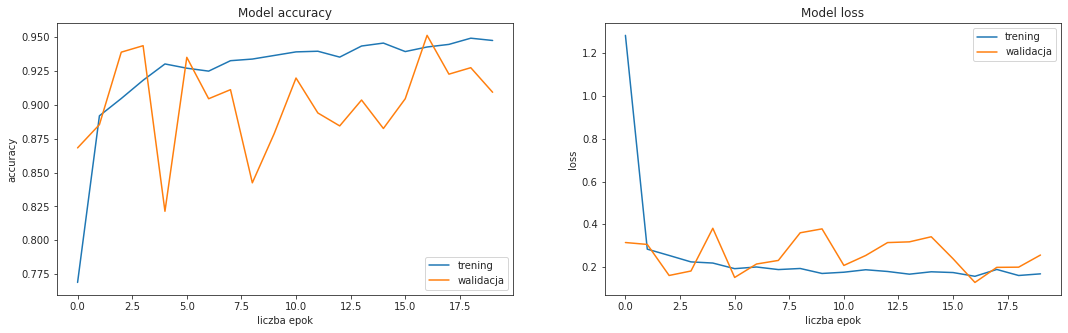

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history1.history[element])
    axis[i].plot(history1.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('liczba epok')
    axis[i].set_ylabel(element)
    axis[i].legend(['trening', 'walidacja'])

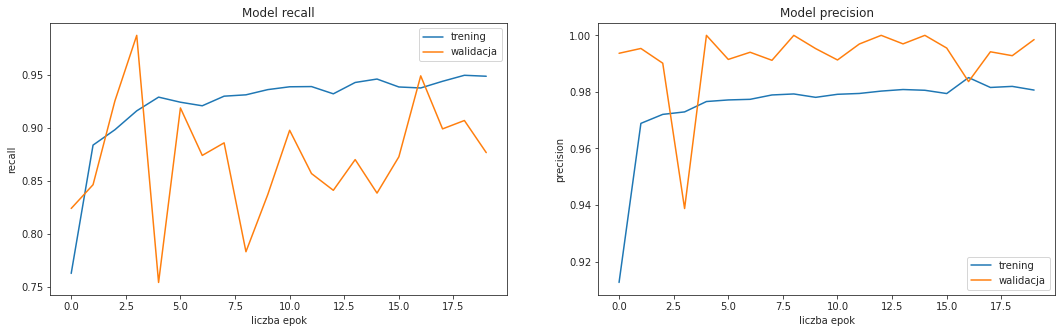

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['recall', 'precision']):
    axis[i].plot(history1.history[element])
    axis[i].plot(history1.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('liczba epok')
    axis[i].set_ylabel(element)
    axis[i].legend(['trening', 'walidacja'])

In [ ]:
Inception_model = tf.keras.models.load_model('/content/model2_inceptionNet.h5')

wrong_predicted_image = [[],[]]
correct_predicted_image = [[],[]]
i = 0
while i< 5 and len(wrong_predicted_image[0]) < 6:
    j = 0
    while j < 32 and len(wrong_predicted_image[0]) < 6:
        
        image_array = (test_generator[i][0][j]).reshape(1,300,300,3)
        
        prediction = Inception_model.predict(image_array)
        
        if int(round(prediction[0][0])) != test_generator[i][1][j]:
            wrong_predicted_image[0].append(image_array)
            wrong_predicted_image[1].append(int(round(prediction[0][0])))
            
        elif len(correct_predicted_image[0]) < 6:
            correct_predicted_image[0].append(image_array)
            correct_predicted_image[1].append(int(round(prediction[0][0])))
        j += 1
        
    i += 1

Źle sklasyfikowane --- [1, 1, 1, 1, 1, 1]


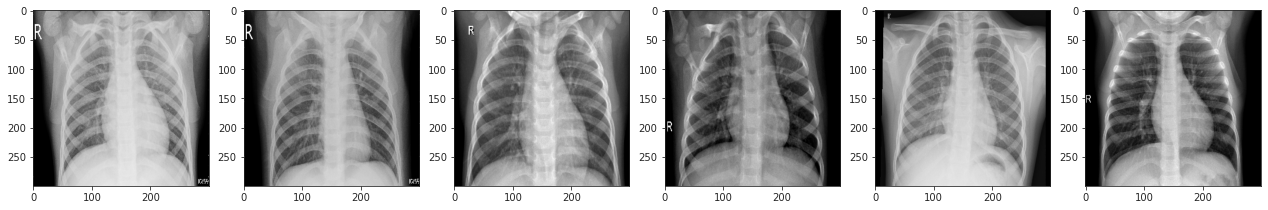

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in wrong_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'Źle sklasyfikowane --- {wrong_predicted_image[1]}')

Poprawnie sklasyfikowane --- [1, 1, 1, 1, 1, 0]


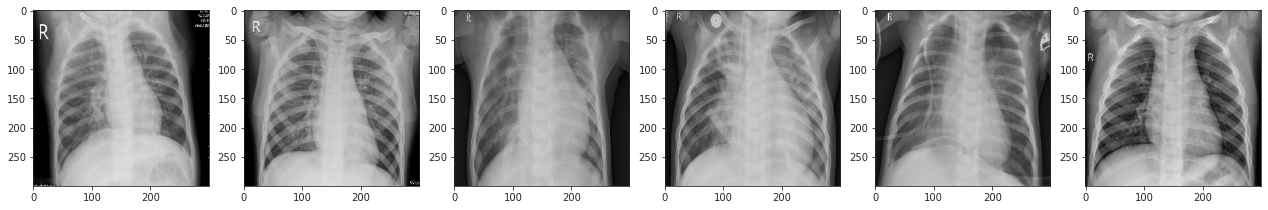

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in correct_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'Poprawnie sklasyfikowane --- {correct_predicted_image[1]}')

# **ResNet**

In [ ]:
base_model4 = tf.keras.applications.ResNet50(input_shape=(300, 300, 3),include_top=False, weights='imagenet')
base_model4.trainable = False

model4 = tf.keras.Sequential([
        base_model4,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,activation=tf.nn.sigmoid),
        ])

model4.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics = ['accuracy', 'Recall', 'Precision'])
model4.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
checkpoint_cb4= tf.keras.callbacks.ModelCheckpoint("model4_resnet.h5",
                                                    save_best_only=True)

early_stopping_cb4 = tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience=50, mode = 'min',restore_best_weights=True)
                                                     

In [ ]:
history4 = model4.fit(
    train_generator,
    steps_per_epoch = 130,
    epochs = epochs,
    validation_data = validation_generator,
    class_weight = class_weight,
    callbacks = [checkpoint_cb4, early_stopping_cb4] 
)

Epoch 1/20
130/130 [==============================] - 129s 960ms/step - loss: 0.7006 - accuracy: 0.5292 - recall: 0.5590 - precision: 0.7488 - val_loss: 0.6188 - val_accuracy: 0.7268 - val_recall: 1.0000 - val_precision: 0.7268
Epoch 2/20
130/130 [==============================] - 123s 943ms/step - loss: 0.6746 - accuracy: 0.5787 - recall: 0.5892 - precision: 0.7937 - val_loss: 0.6639 - val_accuracy: 0.7746 - val_recall: 0.7096 - val_precision: 0.9730
Epoch 3/20
130/130 [==============================] - 123s 944ms/step - loss: 0.6604 - accuracy: 0.6682 - recall: 0.6730 - precision: 0.8512 - val_loss: 0.6632 - val_accuracy: 0.6982 - val_recall: 0.5913 - val_precision: 0.9890
Epoch 4/20
130/130 [==============================] - 122s 938ms/step - loss: 0.6455 - accuracy: 0.6979 - recall: 0.6945 - precision: 0.8721 - val_loss: 0.6697 - val_accuracy: 0.6046 - val_recall: 0.4586 - val_precision: 0.9943
Epoch 5/20
130/130 [==============================] - 122s 938ms/step - loss: 0.6308 - a

In [ ]:
eval_result4 = model4.evaluate_generator(test_generator, 624)
print('loss rate at evaluation data :', eval_result4[0])
print('accuracy rate at evaluation data :', eval_result4[1])
print('precision', eval_result4[2])
print('recall', eval_result4[3])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


loss rate at evaluation data : 0.5082329511642456
accuracy rate at evaluation data : 0.7948718070983887
precision 0.8974359035491943
recall 0.7990867495536804


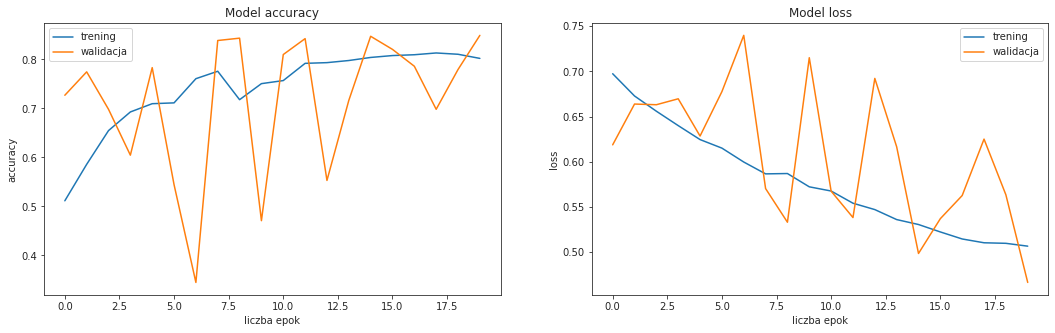

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['accuracy', 'loss']):
    axis[i].plot(history4.history[element])
    axis[i].plot(history4.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('liczba epok')
    axis[i].set_ylabel(element)
    axis[i].legend(['trening', 'walidacja'])

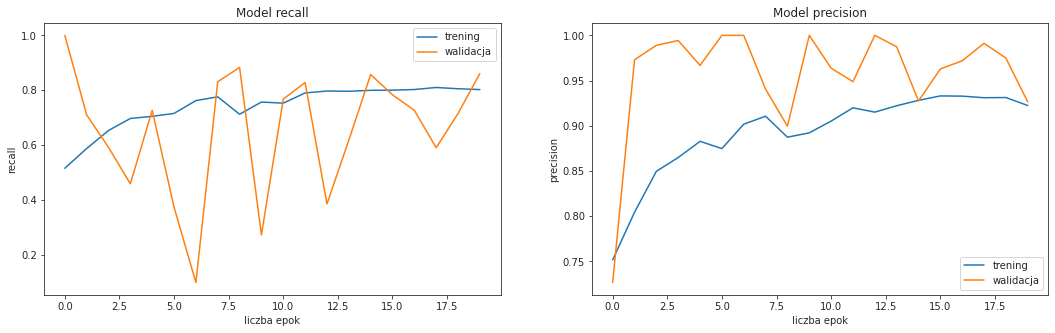

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(18,5))
axis = axis.ravel()

for i,element in enumerate(['recall', 'precision']):
    axis[i].plot(history4.history[element])
    axis[i].plot(history4.history['val_' + element])
    axis[i].set_title('Model {}'.format(element))
    axis[i].set_xlabel('liczba epok')
    axis[i].set_ylabel(element)
    axis[i].legend(['trening', 'walidacja'])

In [ ]:
Resnet_model = tf.keras.models.load_model('/content/model4_resnet.h5')

wrong_predicted_image = [[],[]]
correct_predicted_image = [[],[]]
i = 0
while i< 5 and len(wrong_predicted_image[0]) < 6:
    j = 0
    while j < 32 and len(wrong_predicted_image[0]) < 6:
        
        image_array = (test_generator[i][0][j]).reshape(1,300,300,3)
        
        prediction = Resnet_model.predict(image_array)
        
        if int(round(prediction[0][0])) != test_generator[i][1][j]:
            wrong_predicted_image[0].append(image_array)
            wrong_predicted_image[1].append(int(round(prediction[0][0])))
            
        elif len(correct_predicted_image[0]) < 6:
            correct_predicted_image[0].append(image_array)
            correct_predicted_image[1].append(int(round(prediction[0][0])))
        j += 1
        
    i += 1

Źle sklasyfikowane --- [0, 0, 1, 1, 1, 1]


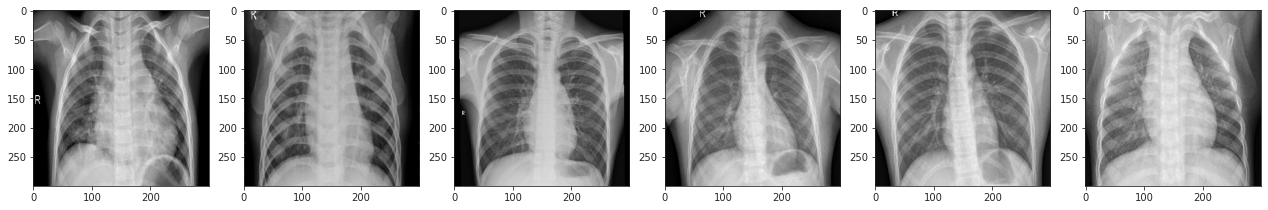

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in wrong_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'Źle sklasyfikowane --- {wrong_predicted_image[1]}')

Poprawnie sklasyfikowane --- [1, 1, 1, 0, 1, 0]


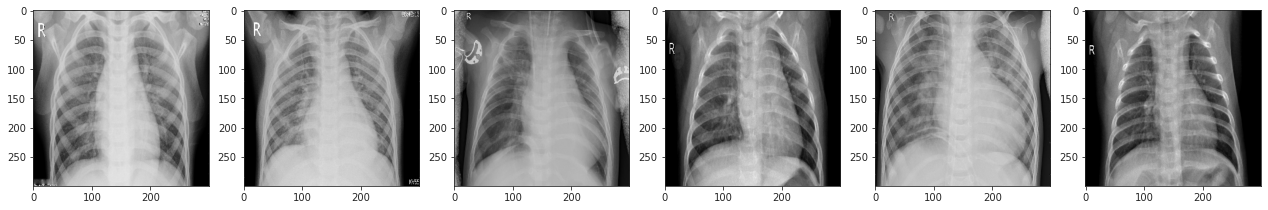

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 22 ,4
fig, ax = plt.subplots(1,6)

i = 0
for ele in correct_predicted_image[0]:
    image = tf.keras.preprocessing.image.array_to_img(ele.reshape(300,300,3))
    ax[i].imshow(image)
    i += 1

print(f'Poprawnie sklasyfikowane --- {correct_predicted_image[1]}')